In [100]:
import pandas as pd
import sys
sys.path.append('/home/brayan/mnsun/')
from utils import check_dir
import os

## Create Scrip 

In [101]:
actual_date   = "20181103" #"".join(str(os.environ["date_processing"]).split("-"))
base_line     = "wget https://noaa-cfs-pds.s3.amazonaws.com/cfs.{ACTUAL_DATE}/{INIT}/6hrly_grib_{ENS}/ocnf{DATE_FORECAST}{INIT_FORE}.{ENS}.{ACTUAL_DATE}{INIT}.grb2"
OUTPUT_DIR    = "/home/brayan/DATA/AWS/" #str(os.environ["output"])
check_dir( OUTPUT_DIR, name=actual_date)
init_hour     = {"00":"06", "06":"12", "12":"18", "18":"00"}
date_forecast = pd.date_range(actual_date, freq="D", periods=45+1)

In [102]:
date_forecast

DatetimeIndex(['2018-11-03', '2018-11-04', '2018-11-05', '2018-11-06',
               '2018-11-07', '2018-11-08', '2018-11-09', '2018-11-10',
               '2018-11-11', '2018-11-12', '2018-11-13', '2018-11-14',
               '2018-11-15', '2018-11-16', '2018-11-17', '2018-11-18',
               '2018-11-19', '2018-11-20', '2018-11-21', '2018-11-22',
               '2018-11-23', '2018-11-24', '2018-11-25', '2018-11-26',
               '2018-11-27', '2018-11-28', '2018-11-29', '2018-11-30',
               '2018-12-01', '2018-12-02', '2018-12-03', '2018-12-04',
               '2018-12-05', '2018-12-06', '2018-12-07', '2018-12-08',
               '2018-12-09', '2018-12-10', '2018-12-11', '2018-12-12',
               '2018-12-13', '2018-12-14', '2018-12-15', '2018-12-16',
               '2018-12-17', '2018-12-18'],
              dtype='datetime64[ns]', freq='D')

In [103]:
for ens in ["01"]: #,"02", "03", "04"
    check_dir( OUTPUT_DIR+f"/{actual_date}/", name=ens)
    with open(f"{OUTPUT_DIR}" + f"/{actual_date}/{ens}/" + actual_date + "_download.txt", "w") as f:
        for hour in ["00", "06", "12", "18"]:
            for t in range(45):
                if t == 0:
                    f.write(base_line.format(ACTUAL_DATE = actual_date, INIT = hour, ENS = ens, INIT_FORE = init_hour[hour],
                                             DATE_FORECAST = ''.join(str(date_forecast[t+1])[:10].split("-")) if hour == "18" else ''.join(str(date_forecast[t])[:10].split("-")) )+ "\n")
                else:
                    if hour == "18":
                        f.write(base_line.format(ACTUAL_DATE = actual_date, INIT = hour, ENS = ens, INIT_FORE = hour,
                                 DATE_FORECAST = ''.join(str(date_forecast[t])[:10].split("-")) if hour == "18" else ''.join(str(date_forecast[t])[:10].split("-")) )+ "\n")
                    else:
                        f.write(base_line.format(ACTUAL_DATE = actual_date, INIT = hour, ENS = ens, INIT_FORE = hour,
                                 DATE_FORECAST = ''.join(str(date_forecast[t+1])[:10].split("-")) if hour == "18" else ''.join(str(date_forecast[t])[:10].split("-")) )+ "\n")

# Data Missing

In [105]:
#!/usr/bin/env python
import os
import glob
import pandas as pd

actual_date   = "20181103" #"".join(str(os.environ["date_processing"]).split("-"))
OUTPUT_DIR    = "/home/brayan/DATA/AWS/" #str(os.environ["output"])

In [106]:
for ens in ["01"]: #,"02", "03", "04"
    list_exist = [ ff.split("/")[-1] for ff in glob.glob(f"/home/brayan/DATA/AWS/{actual_date}/{ens}/*grb2")]
    list_create = []
    list_original = []
    with open (f"/home/brayan/DATA/AWS/{actual_date}/{ens}/"+actual_date +"_download.txt", 'r') as myfile:
        for myline in myfile:           
            list_create.append(myline.split("/")[-1][:-1])
            list_original.append(myline)

    if len(list_create) == len(list_exist):
        with open(f"{OUTPUT_DIR}" + f"/{actual_date}/{ens}/" + actual_date + "_download.txt", "w") as f:
            f.write(" ")
    else:
        list_missing = list_create.copy()        
        [list_missing.remove(i) for i in list_exist]
        list_final = []
        for miss in list_missing:
            for find in list_original:
                if find[73:-1] == miss:
                    list_final.append(find)    
        with open(f"{OUTPUT_DIR}" + f"/{actual_date}/{ens}/" + actual_date + "_download.txt", "w") as f:
            for re in list_final:
                date = pd.date_range( re[77:77+4]+ "-" +re[77+4:77+6]+"-" + re[77+6:77+8] +" " +re[77+8:77+10] + ":00:00", periods=1, freq='6H').shift(6, freq='H')
                f.write(re[:77]+str(date.values[0])[:4]+str(date.values[0])[5:7]+str(date.values[0])[8:10]+str(date.values[0])[11:13]+re[87:])

# Create day data

In [107]:
import xarray as xr
import warnings
import numpy as np
import pandas as pd
import xesmf as xe
import glob
import re
import sys
import os
sys.path.append('/home/brayan/mnsun/')
from utils import check_dir
warnings.filterwarnings('ignore')

In [108]:
# Dictorionary acumulation
day_year = {}
acum     = 0
day_year["01"] = acum
for contador, dm in enumerate([31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30]):
    acum += dm
    if contador < 8:
        day_year[f"0{contador+2}"] = acum
    else: 
        day_year[f"{contador+2}"] = acum

In [109]:
# Start code
actual_date = "20181103" # "".join(str(os.environ["date_processing"]).split("-"))
OUTPUT_DIR  = "/home/brayan/DATA/AWS/" #str(os.environ["output"])

In [110]:
var = "uflx"

In [111]:
ens = "01"

In [112]:
dict_vars = {}

In [113]:
for hour_utc in ["00","06","12","18"]:
    list_exist = glob.glob(OUTPUT_DIR+actual_date+f"/{ens}/*{actual_date}{hour_utc}.grb2")
    list_exist.sort()
    DATA = xr.open_mfdataset(list_exist, engine="cfgrib", concat_dim = 'time',
                         combine='nested',filter_by_keys={'typeOfLevel': 'surface'}).sel(latitude=slice(30,-30),
                                                                           longitude=slice(90,298))
    dates_day = pd.date_range(actual_date[:4]+"-"+actual_date[4:6]+"-"+actual_date[6:], periods=45, freq="D")
    
    list_missing = []
    with open (f"/home/brayan/DATA/AWS/{actual_date}/{ens}/"+actual_date +"_download.txt", 'r') as myfile:
        for myline in myfile:           
            list_missing.append(myline)
            
    # Para la hora 18
    pattern = re.compile(".*"+actual_date+f"{hour_utc}.grb2\n")
    newlist = list(filter(pattern.match, list_missing))
    if len(newlist) != 0:
        for lt in newlist:
            if lt.split("ocnf")[-1][:10] == ''.join(str(pd.date_range(actual_date, periods=2, freq="D")[-1])[:10].split("-"))+"18":
                date_miss = ''.join(str(pd.date_range(actual_date, periods=2, freq="D")[-1])[:10].split("-"))
            else:
                date_miss = lt.split("ocnf")[-1][:8]
            dates_day = dates_day.drop(date_miss)
        DATA["time"]  = dates_day
        date_interp   = pd.date_range(actual_date[:4]+"-"+actual_date[4:6]+"-"+actual_date[6:], periods=45, freq="D")
        VAR1          = getattr(DATA, var).interp(latitude=np.arange(30,-30-.5,-.5)).chunk(chunks={'time': -1}).interp(time=date_interp).rename(longitude="lon").rename(latitude="lat")    
    else:
        DATA["time"]  = dates_day
        VAR1          = getattr(DATA, var).interp(latitude=np.arange(30,-30-.5,-.5)).rename(longitude="lon").rename(latitude="lat")
    VAR1 = VAR1.interpolate_na(dim="lon", method="zero", fill_value="extrapolate")
    dict_vars[hour_utc] = VAR1

In [117]:
VAR_ = xr.concat([ dict_vars["00"].expand_dims("hours"), dict_vars["06"].expand_dims("hours"),
                   dict_vars["12"].expand_dims("hours"), dict_vars["18"].expand_dims("hours")], dim="hours").assign_coords( hours = ("hours",
                   pd.date_range(actual_date[:4]+"-"+actual_date[4:6]+"-"+actual_date[6:], periods=4, freq="6H"))).mean("hours") 

In [118]:
VAR_

,Array,Chunk
Bytes,4.55 MB,101.16 kB
Shape,"(45, 121, 209)","(1, 121, 209)"
Count,2762 Tasks,45 Chunks
Type,float32,numpy.ndarray


In [116]:
dict_vars["18"]

,Array,Chunk
Bytes,4.55 MB,101.16 kB
Shape,"(45, 121, 209)","(1, 121, 209)"
Count,545 Tasks,45 Chunks
Type,float32,numpy.ndarray


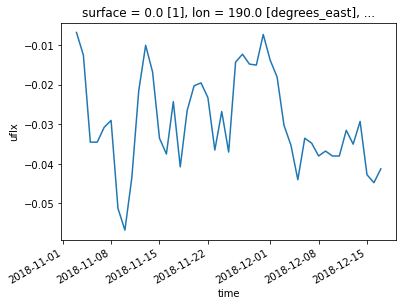

In [120]:
VAR_.isel(lat=60,lon=100).plot()

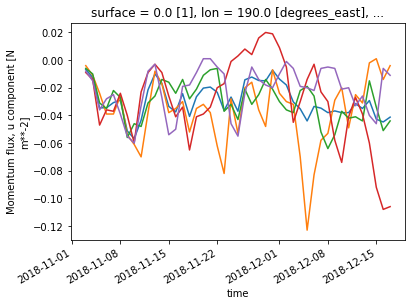

In [121]:
VAR_.isel(lat=60,lon=100).plot()
dict_vars["00"].isel(lat=60,lon=100).plot()
dict_vars["06"].isel(lat=60,lon=100).plot()
dict_vars["12"].isel(lat=60,lon=100).plot()
dict_vars["18"].isel(lat=60,lon=100).plot()

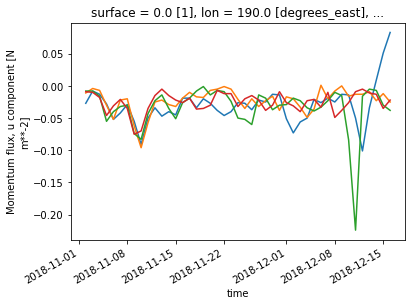

In [99]:
dict_vars["00"].isel(lat=60,lon=100).plot()
dict_vars["06"].isel(lat=60,lon=100).plot()
dict_vars["12"].isel(lat=60,lon=100).plot()
dict_vars["18"].isel(lat=60,lon=100).plot()

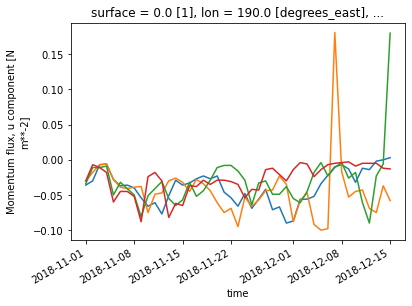

In [81]:
dict_vars["00"].isel(lat=60,lon=100).plot()
dict_vars["06"].isel(lat=60,lon=100).plot()
dict_vars["12"].isel(lat=60,lon=100).plot()
dict_vars["18"].isel(lat=60,lon=100).plot()

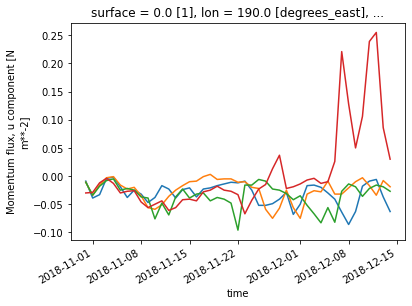

In [27]:
dict_vars["00"].isel(lat=60,lon=100).plot()
dict_vars["06"].isel(lat=60,lon=100).plot()
dict_vars["12"].isel(lat=60,lon=100).plot()
dict_vars["18"].isel(lat=60,lon=100).plot()

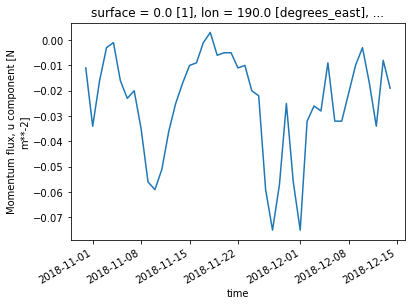

In [25]:
dict_vars["06"].isel(lat=60,lon=100).plot()

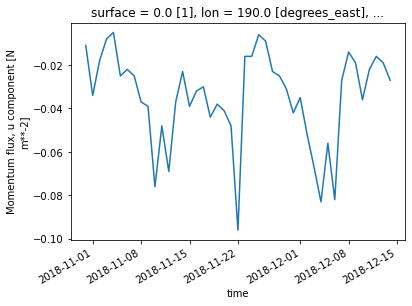

In [26]:
dict_vars["12"].isel(lat=60,lon=100).plot()

In [37]:
hour_utc = "18"

In [38]:
list_exist = glob.glob(OUTPUT_DIR+actual_date+f"/{ens}/*{actual_date}{hour_utc}.grb2")
list_exist.sort()

In [39]:
DATA = xr.open_mfdataset(list_exist, engine="cfgrib", concat_dim = 'time',
                         combine='nested',filter_by_keys={'typeOfLevel': 'surface'}).sel(latitude=slice(30,-30),
                                                                           longitude=slice(90,298))

Ignoring index file '/home/brayan/DATA/AWS/20181031/01/ocnf2018110100.01.2018103118.grb2.923a8.idx' incompatible with GRIB file
Ignoring index file '/home/brayan/DATA/AWS/20181031/01/ocnf2018110218.01.2018103118.grb2.923a8.idx' incompatible with GRIB file
Ignoring index file '/home/brayan/DATA/AWS/20181031/01/ocnf2018110318.01.2018103118.grb2.923a8.idx' incompatible with GRIB file
Ignoring index file '/home/brayan/DATA/AWS/20181031/01/ocnf2018110418.01.2018103118.grb2.923a8.idx' incompatible with GRIB file
Ignoring index file '/home/brayan/DATA/AWS/20181031/01/ocnf2018110518.01.2018103118.grb2.923a8.idx' incompatible with GRIB file
Ignoring index file '/home/brayan/DATA/AWS/20181031/01/ocnf2018110618.01.2018103118.grb2.923a8.idx' incompatible with GRIB file
Ignoring index file '/home/brayan/DATA/AWS/20181031/01/ocnf2018110718.01.2018103118.grb2.923a8.idx' incompatible with GRIB file
Ignoring index file '/home/brayan/DATA/AWS/20181031/01/ocnf2018110818.01.2018103118.grb2.923a8.idx' inco

In [41]:
dates_day = pd.date_range(actual_date[:4]+"-"+actual_date[4:6]+"-"+actual_date[6:], periods=45, freq="D")

In [47]:
list_missing = []
with open (f"/home/brayan/DATA/AWS/{actual_date}/{ens}/"+actual_date +"_download.txt", 'r') as myfile:
    for myline in myfile:           
        list_missing.append(myline)

In [48]:
# Para la hora 18
pattern = re.compile(".*"+actual_date+"18.grb2\n")
newlist = list(filter(pattern.match, list_missing))
if len(newlist) != 0:
    for lt in newlist:
        if lt.split("ocnf")[-1][:10] == ''.join(str(pd.date_range(actual_date, periods=2, freq="D")[-1])[:10].split("-"))+"18":
            date_miss = ''.join(str(pd.date_range(actual_date, periods=2, freq="D")[-1])[:10].split("-"))
        else:
            date_miss = lt.split("ocnf")[-1][:8]
        dates_day = dates_day.drop(date_miss)
    DATA["time"]  = dates_day
    date_interp   = pd.date_range(actual_date[:4]+"-"+actual_date[4:6]+"-"+actual_date[6:], periods=45, freq="D")
    VAR1          = getattr(DATA, var).interp(latitude=np.arange(30,-30-.5,-.5)).chunk(chunks={'time': -1}).interp(time=date_interp).rename(longitude="lon").rename(latitude="lat")    
else:
    DATA["time"]  = dates_day
    VAR1          = getattr(DATA, var).interp(latitude=np.arange(30,-30-.5,-.5)).rename(longitude="lon").rename(latitude="lat")      

In [51]:
VAR1 = VAR1.interpolate_na(dim="lon", method="zero", fill_value="extrapolate")

In [ ]:
VAR1.isel(lat=60,lon=100).plot()

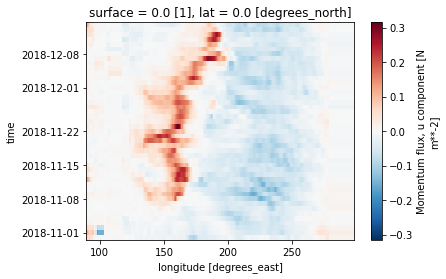

In [55]:
VAR1.sel(lat=0).plot()

In [53]:
VAR1

<xarray.DataArray 'uflx' (time: 45, lat: 121, lon: 209)>
dask.array<transpose, shape=(45, 121, 209), dtype=float32, chunksize=(45, 121, 209), chunktype=numpy.ndarray>
Coordinates:
    surface  float64 0.0
  * lon      (lon) float64 90.0 91.0 92.0 93.0 94.0 ... 295.0 296.0 297.0 298.0
  * lat      (lat) float64 30.0 29.5 29.0 28.5 28.0 ... -28.5 -29.0 -29.5 -30.0
  * time     (time) datetime64[ns] 2018-10-31 2018-11-01 ... 2018-12-14
Attributes:
    GRIB_paramId:                             260062
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      65160
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    GRIB_gridType:                            regular_ll
    GRIB_NV:                                  0
    GRIB_Nx:                                  360
    GRIB_Ny:                                  181
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           uflx
    GRIB_gridDefinitionDescription:           Latitude/longitude. Also called...
    GRIB_iDirectionIncrementInDegrees:        1.0
    GRIB_iScansNegatively:                    0
    GRIB_jDirectionIncrementInDegrees:        1.0
    GRIB_jPointsAreConsecutive:               0
    GRIB_jScansPositively:                    0
    GRIB_latitudeOfFirstGridPointInDegrees:   90.0
    GRIB_latitudeOfLastGridPointInDegrees:    -90.0
    GRIB_longitudeOfFirstGridPointInDegrees:  0.0
    GRIB_longitudeOfLastGridPointInDegrees:   359.0
    GRIB_missingValue:                        9999
    GRIB_name:                                Momentum flux, u component
    GRIB_shortName:                           uflx
    GRIB_units:                               N m**-2
    long_name:                                Momentum flux, u component
    units:                                    N m**-2
    standard_name:                            unknown

In [49]:
VAR1

<xarray.DataArray 'uflx' (time: 45, lat: 121, lon: 209)>
dask.array<transpose, shape=(45, 121, 209), dtype=float32, chunksize=(45, 121, 209), chunktype=numpy.ndarray>
Coordinates:
    surface  float64 0.0
  * lon      (lon) float64 90.0 91.0 92.0 93.0 94.0 ... 295.0 296.0 297.0 298.0
  * lat      (lat) float64 30.0 29.5 29.0 28.5 28.0 ... -28.5 -29.0 -29.5 -30.0
  * time     (time) datetime64[ns] 2018-10-31 2018-11-01 ... 2018-12-14
Attributes:
    GRIB_paramId:                             260062
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      65160
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    GRIB_gridType:                            regular_ll
    GRIB_NV:                                  0
    GRIB_Nx:                                  360
    GRIB_Ny:                                  181
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           uflx
    GRIB_gridDefinitionDescription:           Latitude/longitude. Also called...
    GRIB_iDirectionIncrementInDegrees:        1.0
    GRIB_iScansNegatively:                    0
    GRIB_jDirectionIncrementInDegrees:        1.0
    GRIB_jPointsAreConsecutive:               0
    GRIB_jScansPositively:                    0
    GRIB_latitudeOfFirstGridPointInDegrees:   90.0
    GRIB_latitudeOfLastGridPointInDegrees:    -90.0
    GRIB_longitudeOfFirstGridPointInDegrees:  0.0
    GRIB_longitudeOfLastGridPointInDegrees:   359.0
    GRIB_missingValue:                        9999
    GRIB_name:                                Momentum flux, u component
    GRIB_shortName:                           uflx
    GRIB_units:                               N m**-2
    long_name:                                Momentum flux, u component
    units:                                    N m**-2
    standard_name:                            unknown

In [48]:
VAR1 = VAR1.interpolate_na(dim="lon", method="zero", fill_value="extrapolate")

In [51]:
VAR1

,Array,Chunk
Bytes,4.55 MB,101.16 kB
Shape,"(45, 121, 209)","(1, 121, 209)"
Count,545 Tasks,45 Chunks
Type,float32,numpy.ndarray


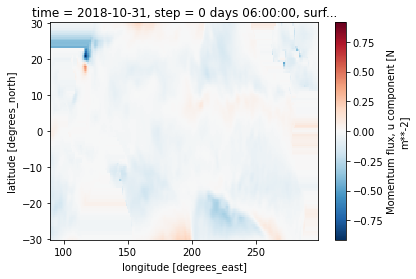

In [49]:
VAR1.isel(time=0).plot()

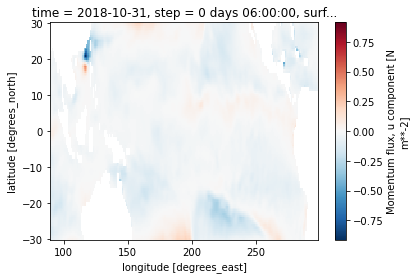

In [47]:
VAR1.isel(time=0).plot()

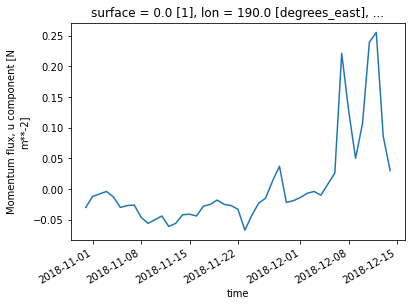

In [52]:
VAR1.isel(lat=60,lon=100).plot()

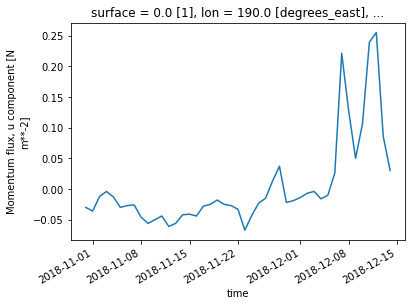

In [50]:
VAR1.isel(lat=60,lon=100).plot()

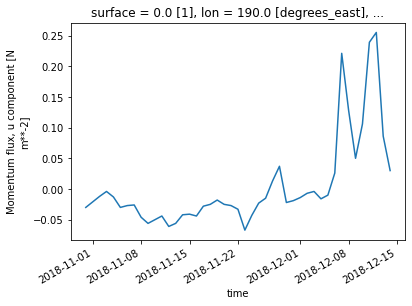

In [33]:
VAR1.isel(lat=60,lon=100).plot()

In [11]:
VAR1

<xarray.DataArray 'uflx' (time: 45, lat: 121, lon: 209)>
dask.array<transpose, shape=(45, 121, 209), dtype=float32, chunksize=(45, 121, 209), chunktype=numpy.ndarray>
Coordinates:
    surface  float64 0.0
  * lon      (lon) float64 90.0 91.0 92.0 93.0 94.0 ... 295.0 296.0 297.0 298.0
  * lat      (lat) float64 30.0 29.5 29.0 28.5 28.0 ... -28.5 -29.0 -29.5 -30.0
  * time     (time) datetime64[ns] 2018-10-31 2018-11-01 ... 2018-12-14
Attributes:
    GRIB_paramId:                             260062
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      65160
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    GRIB_gridType:                            regular_ll
    GRIB_NV:                                  0
    GRIB_Nx:                                  360
    GRIB_Ny:                                  181
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           uflx
    GRIB_gridDefinitionDescription:           Latitude/longitude. Also called...
    GRIB_iDirectionIncrementInDegrees:        1.0
    GRIB_iScansNegatively:                    0
    GRIB_jDirectionIncrementInDegrees:        1.0
    GRIB_jPointsAreConsecutive:               0
    GRIB_jScansPositively:                    0
    GRIB_latitudeOfFirstGridPointInDegrees:   90.0
    GRIB_latitudeOfLastGridPointInDegrees:    -90.0
    GRIB_longitudeOfFirstGridPointInDegrees:  0.0
    GRIB_longitudeOfLastGridPointInDegrees:   359.0
    GRIB_missingValue:                        9999
    GRIB_name:                                Momentum flux, u component
    GRIB_shortName:                           uflx
    GRIB_units:                               N m**-2
    long_name:                                Momentum flux, u component
    units:                                    N m**-2
    standard_name:                            unknown

In [11]:
DATA["time"]  = dates_day

In [14]:
date_interp   = pd.date_range(actual_date[:4]+"-"+actual_date[4:6]+"-"+actual_date[6:], periods=45, freq="D")

In [12]:
VAR1          = getattr(DATA, var).interp(latitude=np.arange(30,-30-.5,-.5)).chunk(chunks={'time': -1}).interp(time=np.arange(30,-30-.5,-.5)).rename(longitude="lon").rename(latitude="lat")

In [13]:
VAR1

,Array,Chunk
Bytes,4.45 MB,101.16 kB
Shape,"(44, 121, 209)","(1, 121, 209)"
Count,400 Tasks,44 Chunks
Type,float32,numpy.ndarray


In [82]:
DATA.time

<xarray.DataArray 'time' (time: 44)>
array(['2018-10-31T00:00:00.000000000', '2018-11-02T00:00:00.000000000',
       '2018-11-03T00:00:00.000000000', '2018-11-04T00:00:00.000000000',
       '2018-11-05T00:00:00.000000000', '2018-11-06T00:00:00.000000000',
       '2018-11-07T00:00:00.000000000', '2018-11-08T00:00:00.000000000',
       '2018-11-09T00:00:00.000000000', '2018-11-10T00:00:00.000000000',
       '2018-11-11T00:00:00.000000000', '2018-11-12T00:00:00.000000000',
       '2018-11-13T00:00:00.000000000', '2018-11-14T00:00:00.000000000',
       '2018-11-15T00:00:00.000000000', '2018-11-16T00:00:00.000000000',
       '2018-11-17T00:00:00.000000000', '2018-11-18T00:00:00.000000000',
       '2018-11-19T00:00:00.000000000', '2018-11-20T00:00:00.000000000',
       '2018-11-21T00:00:00.000000000', '2018-11-22T00:00:00.000000000',
       '2018-11-23T00:00:00.000000000', '2018-11-24T00:00:00.000000000',
       '2018-11-25T00:00:00.000000000', '2018-11-26T00:00:00.000000000',
       '2018-11-27T00:00:00.000000000', '2018-11-28T00:00:00.000000000',
       '2018-11-29T00:00:00.000000000', '2018-11-30T00:00:00.000000000',
       '2018-12-01T00:00:00.000000000', '2018-12-02T00:00:00.000000000',
       '2018-12-03T00:00:00.000000000', '2018-12-04T00:00:00.000000000',
       '2018-12-05T00:00:00.000000000', '2018-12-06T00:00:00.000000000',
       '2018-12-07T00:00:00.000000000', '2018-12-08T00:00:00.000000000',
       '2018-12-09T00:00:00.000000000', '2018-12-10T00:00:00.000000000',
       '2018-12-11T00:00:00.000000000', '2018-12-12T00:00:00.000000000',
       '2018-12-13T00:00:00.000000000', '2018-12-14T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time        (time) datetime64[ns] 2018-10-31 2018-11-02 ... 2018-12-14
    step        (time) timedelta64[ns] 0 days 06:00:00 ... 44 days
    surface     float64 0.0
    valid_time  (time) datetime64[ns] 2018-11-01 ... 2018-12-14T18:00:00

In [8]:
DATA

,Array,Chunk
Bytes,2.29 MB,51.00 kB
Shape,"(45, 61, 209)","(1, 61, 209)"
Count,225 Tasks,45 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,2.29 MB,51.00 kB
Shape,"(45, 61, 209)","(1, 61, 209)"
Count,225 Tasks,45 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [9]:
DATA.time

<xarray.DataArray 'time' (time: 45)>
array(['2018-10-31T00:00:00.000000000', '2018-10-31T00:00:00.000000000',
       '2018-10-31T00:00:00.000000000', '2018-10-31T00:00:00.000000000',
       '2018-10-31T00:00:00.000000000', '2018-10-31T00:00:00.000000000',
       '2018-10-31T00:00:00.000000000', '2018-10-31T00:00:00.000000000',
       '2018-10-31T00:00:00.000000000', '2018-10-31T00:00:00.000000000',
       '2018-10-31T00:00:00.000000000', '2018-10-31T00:00:00.000000000',
       '2018-10-31T00:00:00.000000000', '2018-10-31T00:00:00.000000000',
       '2018-10-31T00:00:00.000000000', '2018-10-31T00:00:00.000000000',
       '2018-10-31T00:00:00.000000000', '2018-10-31T00:00:00.000000000',
       '2018-10-31T00:00:00.000000000', '2018-10-31T00:00:00.000000000',
       '2018-10-31T00:00:00.000000000', '2018-10-31T00:00:00.000000000',
       '2018-10-31T00:00:00.000000000', '2018-10-31T00:00:00.000000000',
       '2018-10-31T00:00:00.000000000', '2018-10-31T00:00:00.000000000',
       '2018-10-31T00:00:00.000000000', '2018-10-31T00:00:00.000000000',
       '2018-10-31T00:00:00.000000000', '2018-10-31T00:00:00.000000000',
       '2018-10-31T00:00:00.000000000', '2018-10-31T00:00:00.000000000',
       '2018-10-31T00:00:00.000000000', '2018-10-31T00:00:00.000000000',
       '2018-10-31T00:00:00.000000000', '2018-10-31T00:00:00.000000000',
       '2018-10-31T00:00:00.000000000', '2018-10-31T00:00:00.000000000',
       '2018-10-31T00:00:00.000000000', '2018-10-31T00:00:00.000000000',
       '2018-10-31T00:00:00.000000000', '2018-10-31T00:00:00.000000000',
       '2018-10-31T00:00:00.000000000', '2018-10-31T00:00:00.000000000',
       '2018-10-31T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time        (time) datetime64[ns] 2018-10-31 2018-10-31 ... 2018-10-31
    step        (time) timedelta64[ns] 0 days 06:00:00 ... 44 days
    surface     float64 0.0
    valid_time  (time) datetime64[ns] 2018-10-31T06:00:00 ... 2018-12-14
Attributes:
    long_name:      initial time of forecast
    standard_name:  forecast_reference_time